# Initialize

In [7]:
import os
import glob
import pickle
import time

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
from pathlib import Path
import re 
import seaborn as sns


# Scikit image
from skimage import color, segmentation, filters, measure, morphology
from skimage.io import imread
from skimage.segmentation import slic
from skimage.measure import regionprops, regionprops_table, find_contours

from scipy import ndimage as ndi
from scipy.ndimage import center_of_mass, gaussian_filter, generic_filter,binary_closing
from scipy.stats import mode
from scipy.ndimage import find_objects, label, center_of_mass


# Cellpose
from cellpose import core, utils, io, models, metrics, plot
from cellpose.io import logger_setup

# Personal 
import importlib
import preprocessing as pp
import lesion_mask as lm

# Image loading modules
from aicsimageio import AICSImage
import stackview

# pyclesperanto
import pyclesperanto_prototype as cle
from pyclesperanto_prototype import imshow

# Getting the data

In [5]:
from pathlib import Path
import re
import glob

# Define the output folder
output_folder = "full_batch_results"

# Locate all pickle files in the folder
pickle_files = glob.glob(os.path.join(output_folder, "lesion_cell_results_week_*_batch_*.pkl"))

# Extract week number from the filenames and group files by week
def extract_week_from_filename(filename):
    match = re.search(r'week_(\d+)', filename)
    return int(match.group(1)) if match else None

# Group files by week
week_groups = {}
for file in pickle_files:
    week = extract_week_from_filename(file)
    if week is not None:
        week_groups.setdefault(week, []).append(file)

# Initialize a list to store all results
all_data = []

# Function to extract metadata from sample name
def extract_metadata(sample_name):
    date_match = re.search(r'^(\d{4}_\d{2}_\d{2})', sample_name)
    week_match = re.search(r'w\.(\d+)', sample_name)
    sample_type_match = re.search(r'(A1\+A2|B1\+B2|A3\+A4|B3\+B4)', sample_name)
    scene_match = re.search(r'Scene_(\d+)', sample_name)
    
    # Initialize metadata dictionary with all fields
    metadata = {
        'Date': date_match.group(1) if date_match else None,
        'Week': int(week_match.group(1)) if week_match else None,
        'Scene': int(scene_match.group(1)) if scene_match else None,
    }

    # Add the Sample Group column before Sample Type
    metadata['Sample Group'] = 'Control' if 'A' in sample_type_match.group(1) else 'Vaccinated'
    metadata['Sample Type'] = sample_type_match.group(1) if sample_type_match else None

    return metadata


# Reorder columns so that 'Sample Group' is before 'Sample Type'
#df = df[['Date', 'Week', 'Sample Group', 'Sample Type', 'Scene']]

# Display the DataFrame with the added 'Sample Group' column
#print(df.head())


# Process each week
for week, files in week_groups.items():
    print(f"Processing week {week} with {len(files)} batches.")

    # Initialize a list to store results for this week
    week_results = []

    for file in files:
        print(f"Loading {file}")
        with open(file, 'rb') as f:
            batch_results = pickle.load(f)
            week_results.append(batch_results)

    # Process each result from all batches in the week
    for batch_results in week_results:
        for sample_name, result in batch_results.items():
            # Extract metrics
            tissue_mask = result.get('tissue_mask')
            lesion_mask = result.get('lesion_mask')
            T_cells = result.get('T_centroids')
            B_cells = result.get('B_centroids')

            tissue_area = np.count_nonzero(tissue_mask)
            lesion_area = np.count_nonzero(lesion_mask)
            total_t_cells = len(T_cells)
            total_t_cells_in_lesion = sum(
                lesion_mask[int(c[0]), int(c[1])] > 0 for c in T_cells
            )
            total_b_cells = len(B_cells)
            total_b_cells_in_lesion = sum(
                lesion_mask[int(c[0]), int(c[1])] > 0 for c in B_cells
            )

             # Calculate the ratios
            lesion_area_ratio = lesion_area / tissue_area if tissue_area > 0 else 0

            t_cells_in_lesion_density = total_t_cells_in_lesion / lesion_area if lesion_area > 0 else 0
            t_cells_in_lesion_ratio = total_t_cells_in_lesion / total_t_cells if total_t_cells > 0 else 0
            
            b_cells_in_lesion_density = total_b_cells_in_lesion / lesion_area if lesion_area > 0 else 0
            b_cells_in_lesion_ratio = total_b_cells_in_lesion / total_b_cells if total_b_cells > 0 else 0
            #print(f"Tissue Area: {tissue_area}, Lesion Area: {lesion_area}, Lesion Area Ratio: {lesion_area_ratio}")

            # Extract metadata and combine with metrics
            metadata = extract_metadata(sample_name)
            
            # Reorder metadata to ensure it goes right after Sample Name
            row = {
                'Sample Name': sample_name,
                **metadata,  # Merge metadata immediately after Sample Name
                'Tissue Area': tissue_area,
                'Lesion Area': lesion_area,
                'Lesion Area Ratio': lesion_area_ratio,
                'Total T Cells': total_t_cells,
                'T Cells in Lesion Density': t_cells_in_lesion_density,
                'T Cells in Lesion': total_t_cells_in_lesion,
                'T Cells in Lesion Ratio': t_cells_in_lesion_ratio,
                'Total B Cells': total_b_cells,
                'B Cells in Lesion Density': b_cells_in_lesion_density,
                'B Cells in Lesion': total_b_cells_in_lesion,
                'B Cells in Lesion Ratio': b_cells_in_lesion_ratio
            }
            all_data.append(row)

# Create the consolidated DataFrame
results_df = pd.DataFrame(all_data)

# Save to a CSV for further analysis
results_df.to_csv('lesion_analysis_summary.csv', index=False)

# Display a preview of the DataFrame
print(results_df.head())

Processing week 4 with 1 batches.
Loading full_batch_results/lesion_cell_results_week_4_batch_1.pkl


Processing week 6 with 1 batches.
Loading full_batch_results/lesion_cell_results_week_6_batch_1.pkl
Processing week 16 with 1 batches.
Loading full_batch_results/lesion_cell_results_week_16_batch_1.pkl
Processing week 2 with 1 batches.
Loading full_batch_results/lesion_cell_results_week_2_batch_1.pkl
                                Sample Name        Date  Week  Scene  \
0  2023_07_14_F2805_w.4 B3+B4_iBALT_Scene_0  2023_07_14     4      0   
1  2023_07_14_F2805_w.4 B3+B4_iBALT_Scene_1  2023_07_14     4      1   
2  2023_07_14_F2805_w.4 A1+A2_iBALT_Scene_0  2023_07_14     4      0   
3  2023_07_14_F2805_w.4 A1+A2_iBALT_Scene_1  2023_07_14     4      1   
4  2023_07_14_F2805_w.4 B1+B2_iBALT_Scene_0  2023_07_14     4      0   

  Sample Group Sample Type  Tissue Area  Lesion Area  Lesion Area Ratio  \
0   Vaccinated       B3+B4    136257280      4409000           0.032358   
1   Vaccinated       B3+B4    245189690      9115270           0.037176   
2      Control       A1+A2    150039268 

# Boxplots

## Individual

Plotting combined boxplots for Control and Vaccinated groups across weeks with T and B cells in lesion ratios


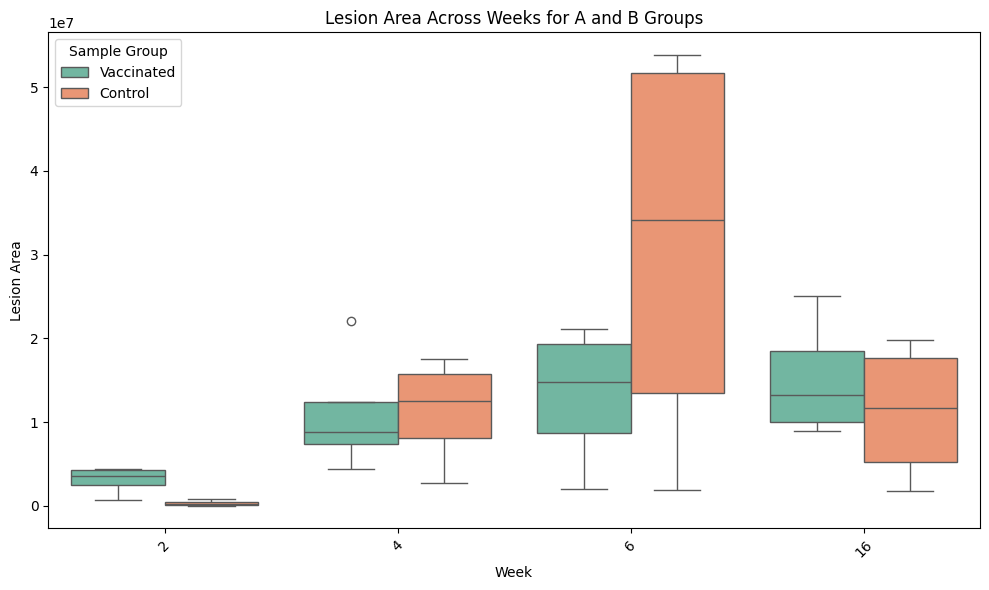

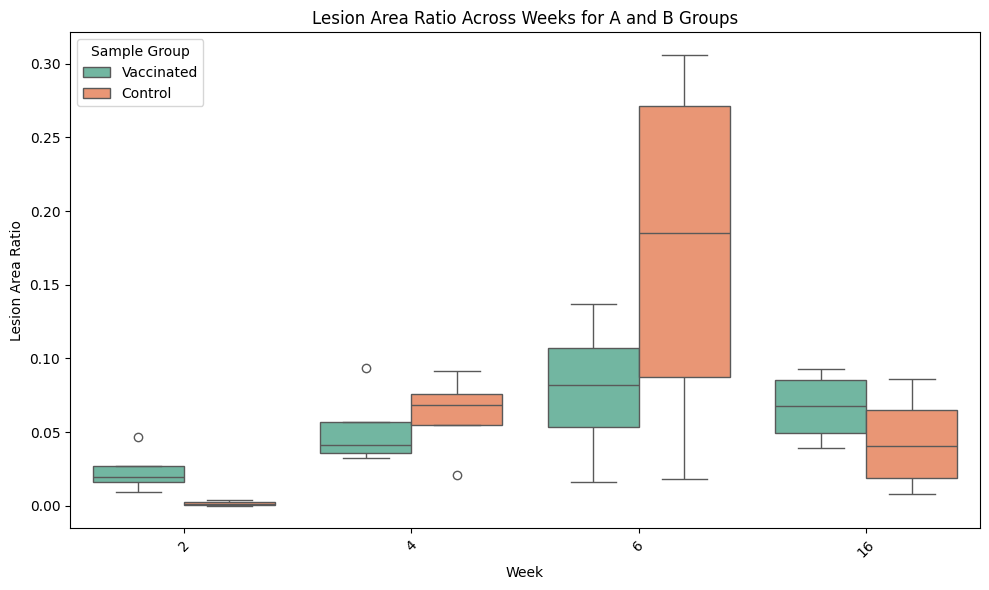

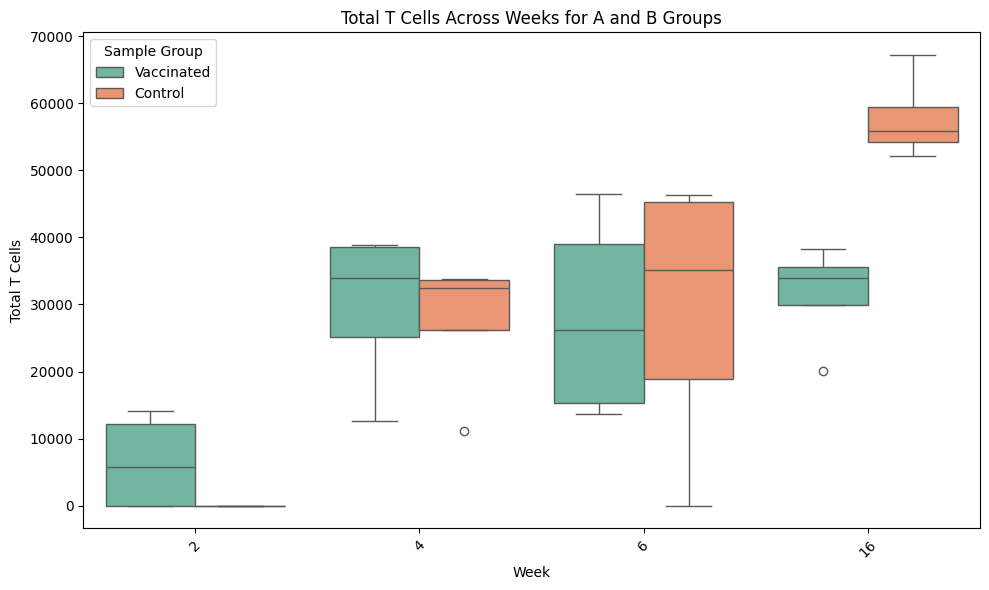

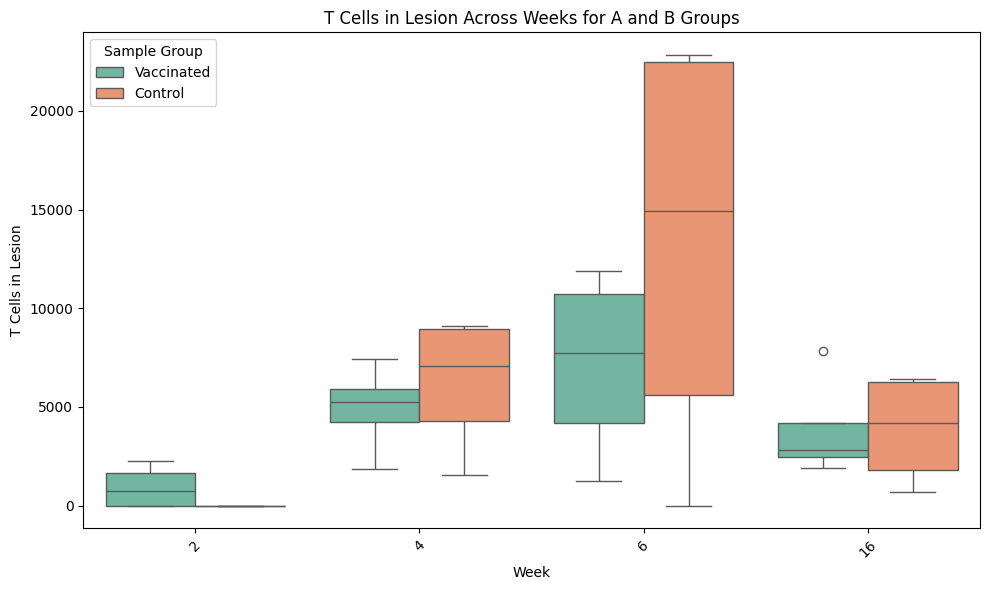

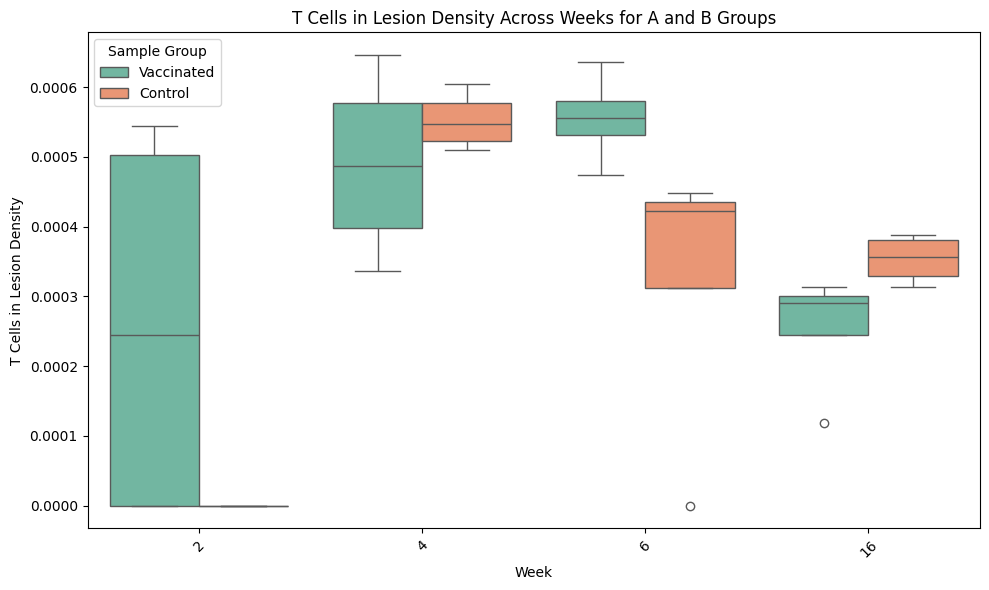

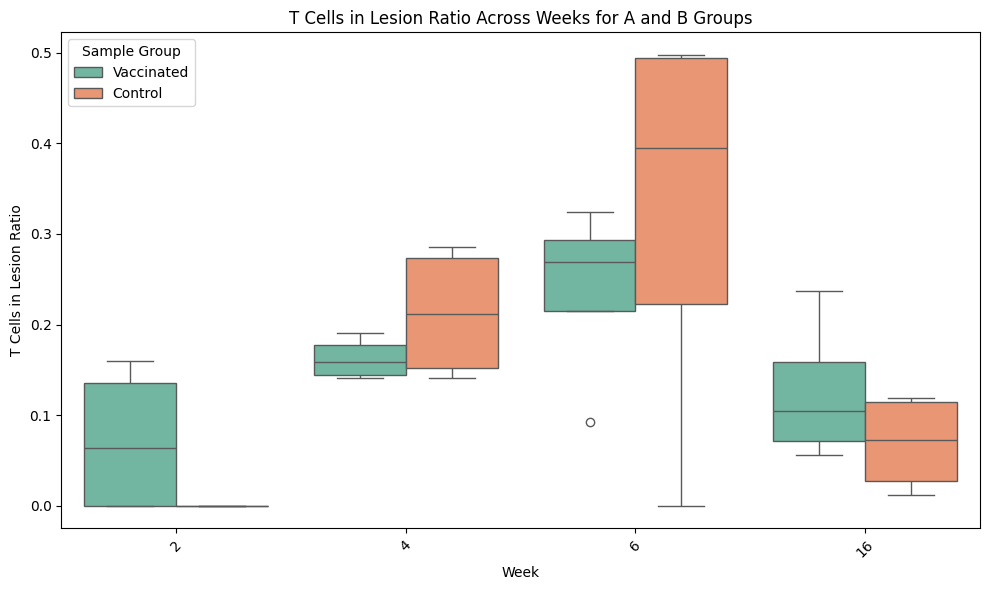

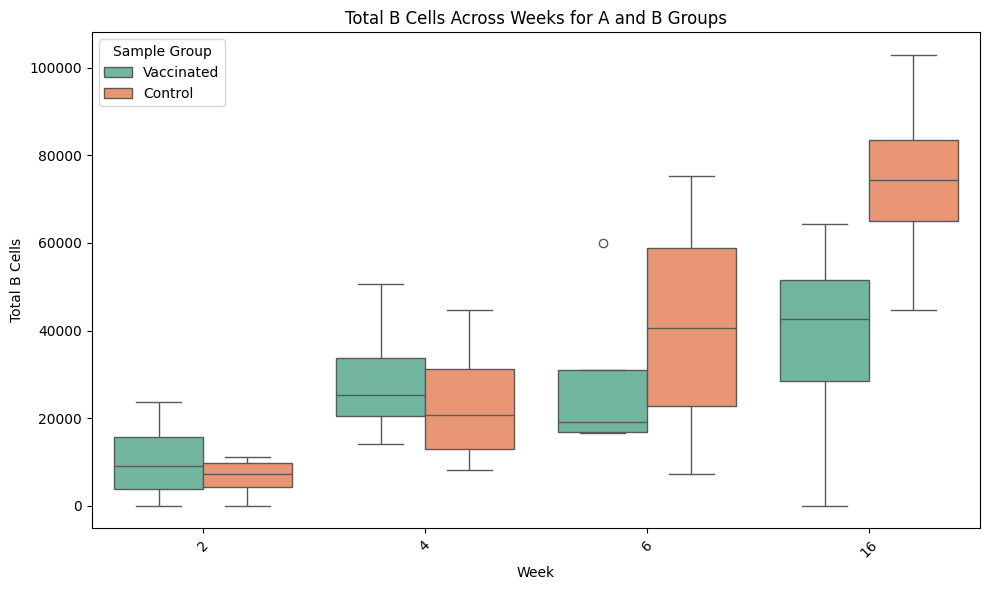

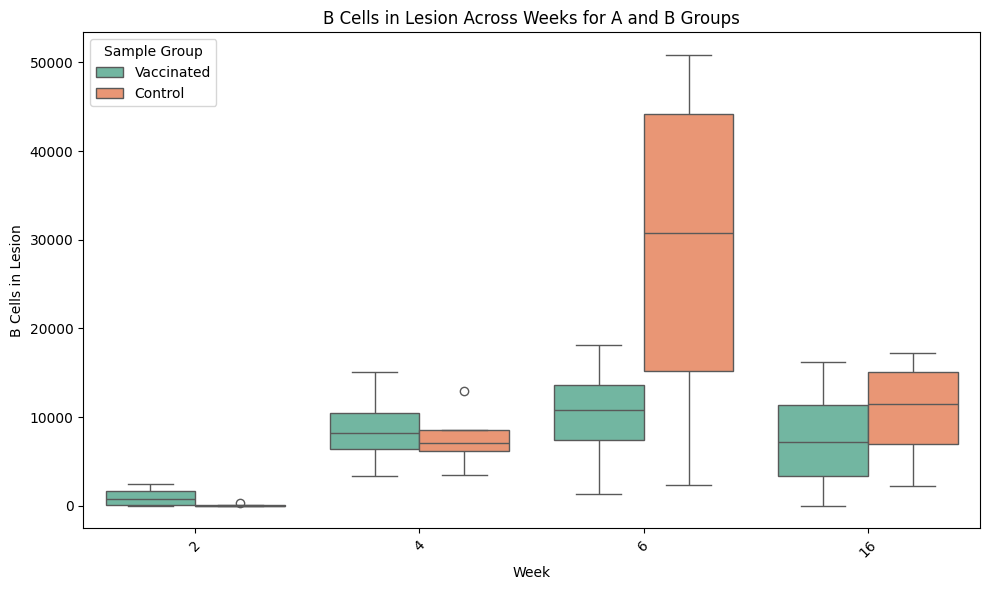

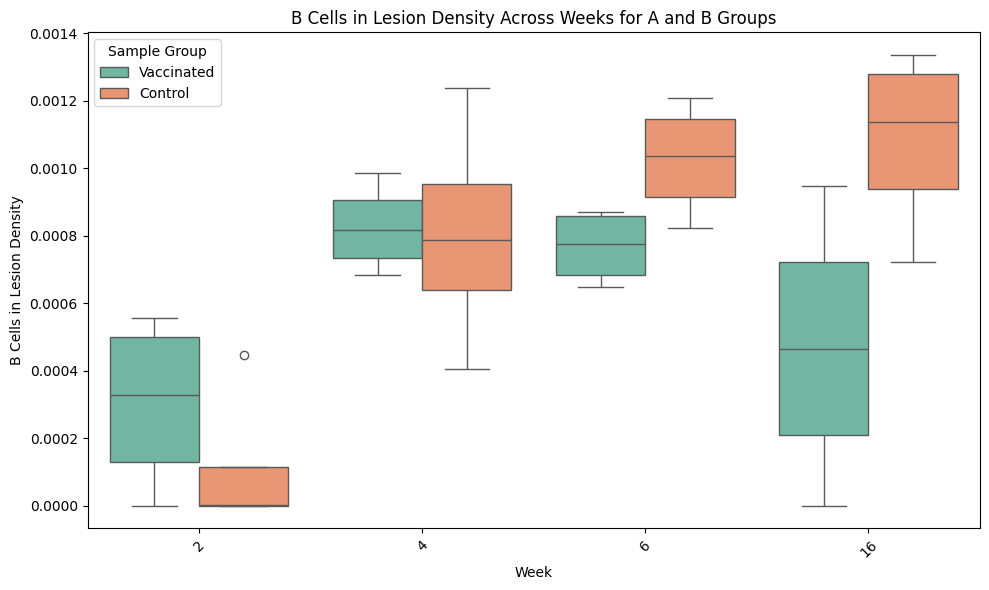

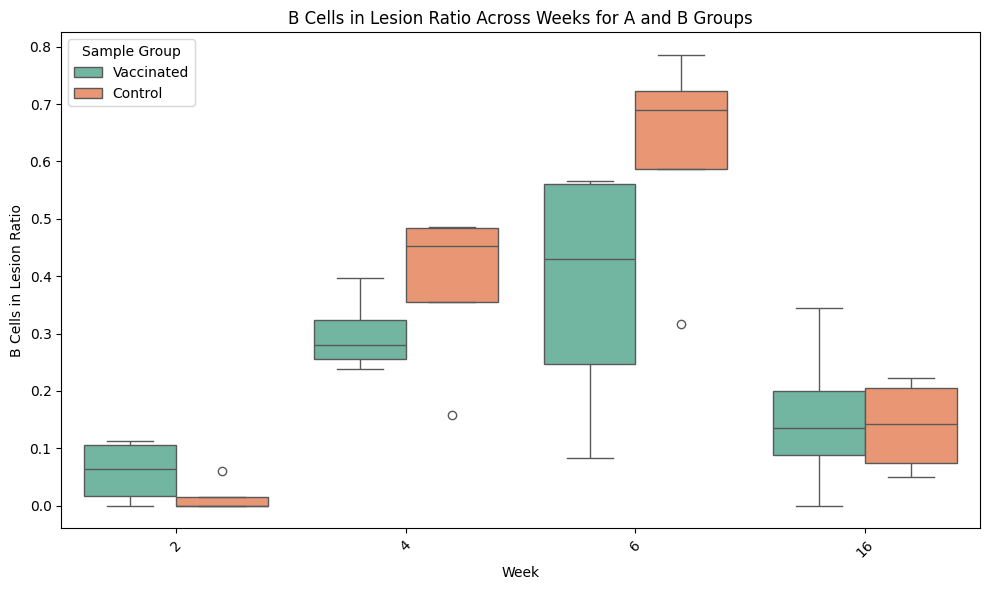

In [9]:
results_df = pd.read_csv('lesion_analysis_summary.csv')

# Define a function to plot the combined boxplot for ratios of T and B cells in lesion
def plot_boxplots_by_week_and_group_for_ratios(df):
    print("Plotting combined boxplots for Control and Vaccinated groups across weeks with T and B cells in lesion ratios")
    
    # Define the columns to analyze (metrics)
    columns_to_analyze = [
        'Lesion Area','Lesion Area Ratio',
        'Total T Cells', 'T Cells in Lesion', 
        'T Cells in Lesion Density', 'T Cells in Lesion Ratio', 
        'Total B Cells', 'B Cells in Lesion', 
        'B Cells in Lesion Density', 'B Cells in Lesion Ratio' 
    ]
    
    # Create a plot for each ratio
    for col in columns_to_analyze:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='Week', y=col, hue='Sample Group', data=df, palette="Set2", dodge=True)
        plt.title(f'{col} Across Weeks for A and B Groups')
        plt.xlabel('Week')
        plt.ylabel(col)
        plt.xticks(rotation=45)
        plt.legend(title="Sample Group", loc='upper left')
        plt.tight_layout()
        plt.show()

# Plot the combined boxplots for the ratios
plot_boxplots_by_week_and_group_for_ratios(results_df)

## Boxplot Divided in Lesion, T and B grouping

Plotting boxplots for Control and Vaccinated groups across weeks with T and B cell metrics in a 5x2 grid.


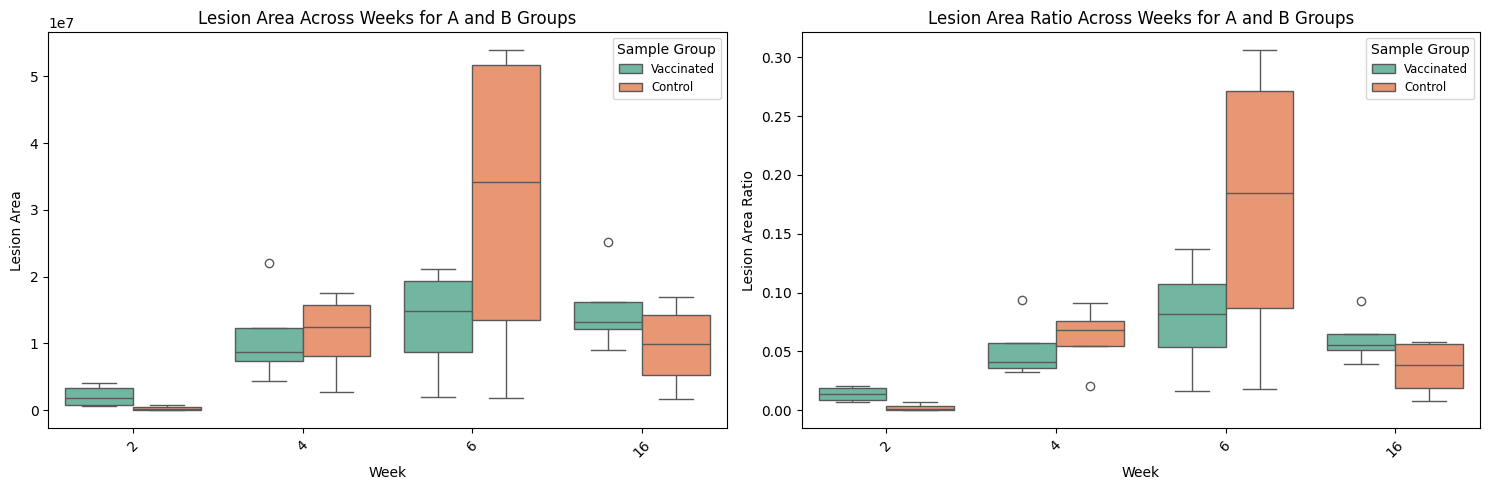

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_boxplots_in_grid(df):
    print("Plotting boxplots for Control and Vaccinated groups across weeks with T and B cell metrics in a 5x2 grid.")
    
    # Define the columns to analyze (metrics)
    columns_to_analyze = [
        'Lesion Area', 'Lesion Area Ratio'
    ]
    
    # Create a grid of subplots
    fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True)
    axes = axes.flatten()  # Flatten the axes array for easy indexing
    
    for i, col in enumerate(columns_to_analyze):
        ax = axes[i]
        sns.boxplot(x='Week', y=col, hue='Sample Group', data=df, palette="Set2", dodge=True, ax=ax)
        ax.set_title(f'{col} Across Weeks for A and B Groups')
        ax.set_xlabel('Week')
        ax.set_ylabel(col)
        ax.tick_params(axis='x', rotation=45)
        ax.legend(title="Sample Group", loc='upper right', fontsize='small', title_fontsize='medium')

    # Hide any unused subplots (in case there are fewer than 10 metrics)
    for j in range(len(columns_to_analyze), len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

# Plot the combined boxplots in a 5x2 grid
plot_boxplots_in_grid(results_df)

Plotting boxplots for Control and Vaccinated groups across weeks with T and B cell metrics in a 5x2 grid.


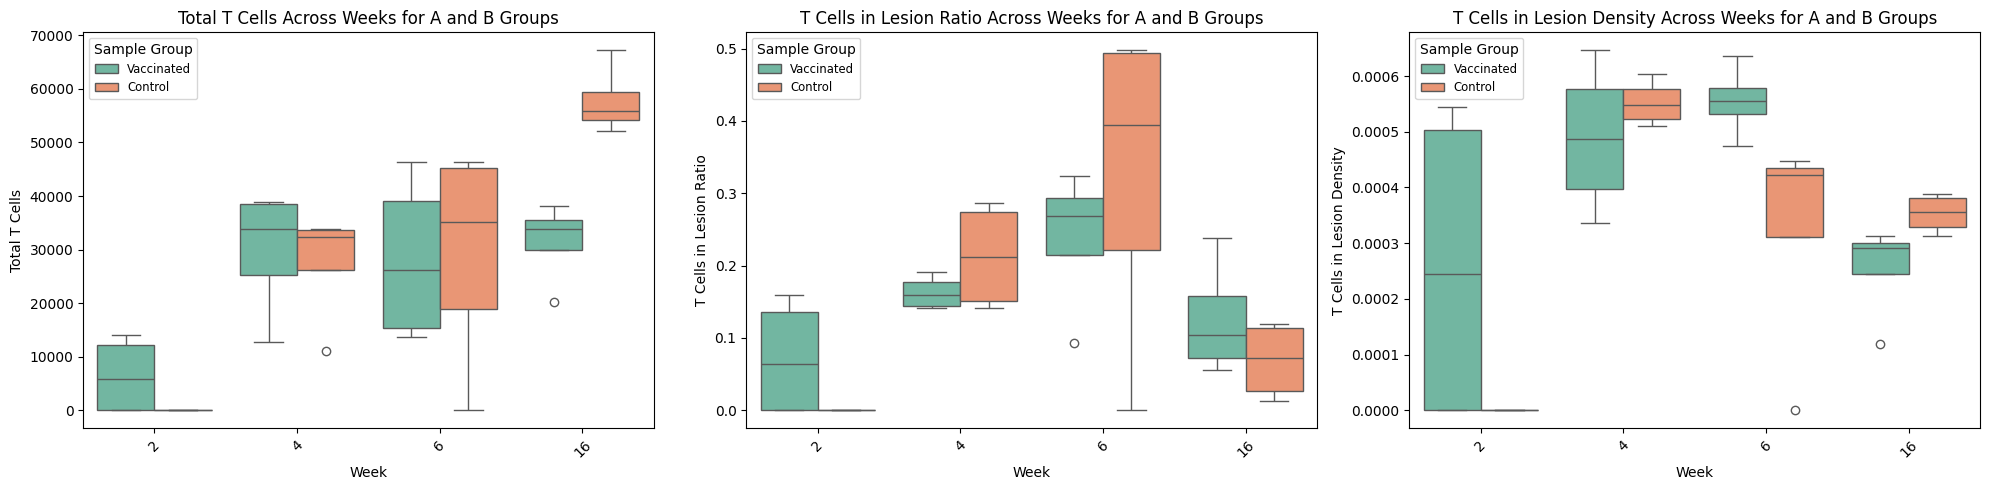

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_boxplots_in_grid(df):
    print("Plotting boxplots for Control and Vaccinated groups across weeks with T and B cell metrics in a 5x2 grid.")
    
    # Define the columns to analyze (metrics)
    columns_to_analyze = [
        'Total T Cells', 'T Cells in Lesion Ratio', 'T Cells in Lesion Density'
    ]
    
    # Create a grid of subplots
    fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharex=True)
    axes = axes.flatten()  # Flatten the axes array for easy indexing
    
    for i, col in enumerate(columns_to_analyze):
        ax = axes[i]
        sns.boxplot(x='Week', y=col, hue='Sample Group', data=df, palette="Set2", dodge=True, ax=ax)
        ax.set_title(f'{col} Across Weeks for A and B Groups')
        ax.set_xlabel('Week')
        ax.set_ylabel(col)
        ax.tick_params(axis='x', rotation=45)
        ax.legend(title="Sample Group", loc='upper left', fontsize='small', title_fontsize='medium')

    # Hide any unused subplots (in case there are fewer than 10 metrics)
    for j in range(len(columns_to_analyze), len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

# Plot the combined boxplots in a 5x2 grid
plot_boxplots_in_grid(results_df)

Plotting boxplots for Control and Vaccinated groups across weeks with T and B cell metrics in a 5x2 grid.


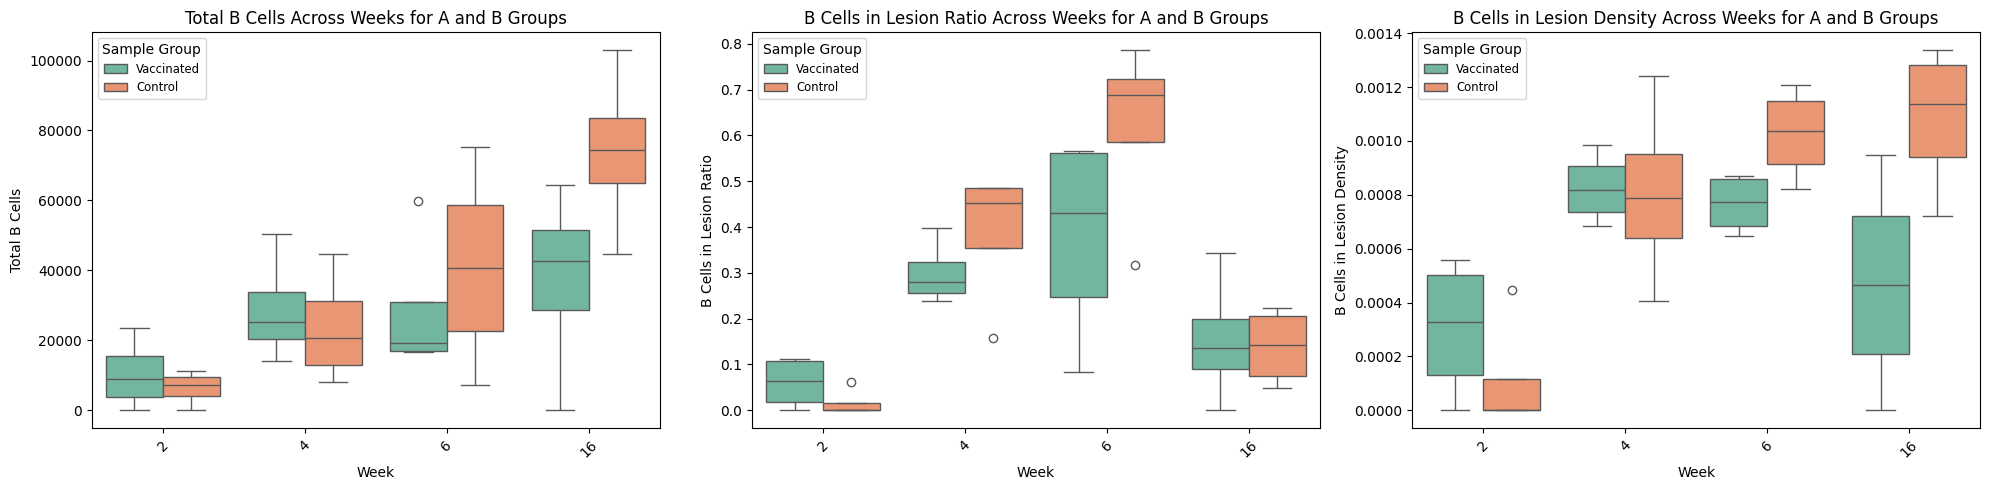

In [58]:

def plot_boxplots_in_grid(df):
    print("Plotting boxplots for Control and Vaccinated groups across weeks with T and B cell metrics in a 5x2 grid.")
    
    # Define the columns to analyze (metrics)
    columns_to_analyze = [
        'Total B Cells', 'B Cells in Lesion Ratio','B Cells in Lesion Density'
    ]
    
    # Create a grid of subplots
    fig, axes = plt.subplots(1, 3, figsize=(20, 5), sharex=True)
    axes = axes.flatten()  # Flatten the axes array for easy indexing
    
    for i, col in enumerate(columns_to_analyze):
        ax = axes[i]
        sns.boxplot(x='Week', y=col, hue='Sample Group', data=df, palette="Set2", dodge=True, ax=ax)
        ax.set_title(f'{col} Across Weeks for A and B Groups')
        ax.set_xlabel('Week')
        ax.set_ylabel(col)
        ax.tick_params(axis='x', rotation=45)
        ax.legend(title="Sample Group", loc='upper left', fontsize='small', title_fontsize='medium')

    # Hide any unused subplots (in case there are fewer than 10 metrics)
    for j in range(len(columns_to_analyze), len(axes)):
        axes[j].axis('off')
    
    plt.tight_layout()
    plt.show()

# Plot the combined boxplots in a 5x2 grid
plot_boxplots_in_grid(results_df)



# Groundtruth comparison

In [32]:
ground_truth_df = pd.read_csv('HEV_lesion_area.tsv', sep='\t')

# Extract the numeric part of the 'week' column and convert it to integer
ground_truth_df['week'] = ground_truth_df['week'].str.extract(r'w(\d+)')[0].astype(int)
ground_truth_df['scene'] = ground_truth_df['scene'].str.extract(r'Scene #(\d+)')[0].astype(int)
ground_truth_df['scene'] = ground_truth_df['scene'].replace({1: 0, 2: 1})
# Preview the cleaned DataFrame
print("\nCleaned DataFrame with numeric weeks:")
print(ground_truth_df.head())


Cleaned DataFrame with numeric weeks:
   week        group sample_id  num_HEV  scene  lesion_area
0     2         Ctrl     A1+A2        0      0       303815
1     2         Ctrl     A1+A2        0      1       348018
2     2         Ctrl     A3+A4        0      0       172963
3     2         Ctrl     A3+A4        0      1       197854
4     2  H107e/CAF01     B1+B2        0      0       232538


In [33]:
# Create the matching key
ground_truth_df['matching_key'] = (
    ground_truth_df['week'].astype(str) + "_" +
    ground_truth_df['sample_id'] + "_" +
    ground_truth_df['scene'].astype(str)
)
#
results_df = pd.read_csv('lesion_analysis_summary.csv')

# Create a matching key for both DataFrames
results_df['matching_key'] = results_df['Week'].astype(str) + "_" + results_df['Sample Type'] + "_" + results_df['Scene'].astype(str)

# Merge the DataFrames on the matching key
merged_df = pd.merge(
    results_df,
    ground_truth_df[['matching_key', 'lesion_area']],
    on='matching_key',
    how='inner',
    suffixes=('_results', '_ground_truth')
)

# Calculate the difference or ratio
merged_df['Lesion Area Difference'] = merged_df['Lesion Area'] - merged_df['lesion_area']
merged_df['Lesion Area Ratio'] = merged_df['Lesion Area'] / merged_df['lesion_area']

# Save the merged DataFrame to a CSV for further analysis
merged_df.to_csv('lesion_area_comparison.csv', index=False)

# Display a preview of the merged DataFrame
#print(merged_df.head())
print(len(merged_df))



32


### Debug

In [48]:
# Check the number of unique matching keys in both DataFrames
print(f"Unique matching keys in results_df: {results_df['matching_key'].nunique()}")
print(f"Unique matching keys in ground_truth_df: {ground_truth_df['matching_key'].nunique()}")


Unique matching keys in results_df: 32
Unique matching keys in ground_truth_df: 32


In [49]:
# Find matching keys present in one DataFrame but not the other
missing_in_ground_truth = set(results_df['matching_key']) - set(ground_truth_df['matching_key'])
missing_in_results = set(ground_truth_df['matching_key']) - set(results_df['matching_key'])

print(f"Matching keys missing in ground_truth_df: {missing_in_ground_truth}")
print(f"Matching keys missing in results_df: {missing_in_results}")


Matching keys missing in ground_truth_df: {'2_A1+A2_0', '6_B3+B4_0', '2_B1+B2_0', '4_A1+A2_0', '4_B3+B4_0', '16_B3+B4_0', '4_A3+A4_0', '6_A3+A4_0', '6_B1+B2_0', '2_B3+B4_0', '16_A1+A2_0', '2_A3+A4_0', '6_A1+A2_0', '16_B1+B2_0', '16_A3+A4_0', '4_B1+B2_0'}
Matching keys missing in results_df: {'4_B3+B4_2', '2_B3+B4_2', '16_A3+A4_2', '16_B3+B4_2', '6_B3+B4_2', '2_A1+A2_2', '2_B1+B2_2', '16_A1+A2_2', '6_B1+B2_2', '4_A3+A4_2', '4_B1+B2_2', '16_B1+B2_2', '2_A3+A4_2', '4_A1+A2_2', '6_A1+A2_2', '6_A3+A4_2'}


In [ ]:
print(f"NaN values in matching_key in results_df: {results_df['matching_key'].isna().sum()}")
print(f"NaN values in matching_key in ground_truth_df: {ground_truth_df['matching_key'].isna().sum()}")


# Pearson and Spearman Stats

In [34]:
from scipy.stats import spearmanr, pearsonr

# Extract the columns to compare
x = merged_df['Lesion Area']
y = merged_df['lesion_area']

# Spearman's Rank Correlation
spearman_corr, spearman_p = spearmanr(x, y)
print(f"Spearman's Rank Correlation: {spearman_corr:.3f}, p-value: {spearman_p:.3f}")


# Pearson Correlation Coefficient
pearson_corr, pearson_p = pearsonr(x, y)
print(f"Pearson Correlation: {pearson_corr:.3f}, p-value: {pearson_p:.3f}")


Spearman's Rank Correlation: 0.734, p-value: 0.000
Pearson Correlation: 0.445, p-value: 0.011


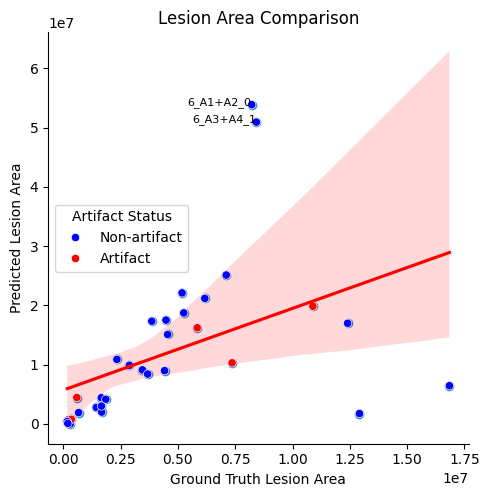

In [50]:
# List of artifact keys
artifact_keys = [
    '2_A1+A2_1',  # Example for w2 A1+A2 Scene 1
    '2_B3+B4_0',  # Example for w2 B3+B4 Scene 0
    '16_A1+A2_1', # Example for w16 A1+A2 Scene 1
    '16_B3+B4_0', # Example for w16 B3+B4 Scene 0
    '16_B3+B4_1', # Example for w16 B3+B4 Scene 1
]

# Calculate the residuals (the difference between predicted and actual values)
residuals = merged_df['Lesion Area'] - merged_df['lesion_area']

# Calculate the IQR for detecting outliers
Q1 = residuals.quantile(0.25)
Q3 = residuals.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers
outliers = merged_df[(residuals < lower_bound) | (residuals > upper_bound)]

# Create a column to color dots based on whether they're artifacts
merged_df['Dot Color'] = merged_df['matching_key'].apply(lambda x: 'Artifact' if x in artifact_keys else 'Non-artifact')

# Scatter plot with trendline
sns.lmplot(data=merged_df, x='lesion_area', y='Lesion Area', line_kws={'color': 'red'})
plt.title('Lesion Area Comparison')
plt.xlabel('Ground Truth Lesion Area')
plt.ylabel('Predicted Lesion Area')

# Plot the dots, color-coded
sns.scatterplot(data=merged_df, x='lesion_area', y='Lesion Area', hue='Dot Color', palette={'Artifact': 'red', 'Non-artifact': 'blue'}, legend=True)

# Add labels for outliers
for i, row in outliers.iterrows():
    plt.text(row['lesion_area'], row['Lesion Area'], row['matching_key'], fontsize=8, ha='right', color='black')

# Show the legend with appropriate labels
plt.legend(title='Artifact Status')

plt.show()


# Absolut difference

In [ ]:
# Create a new DataFrame with relevant information
lesion_differences_df = merged_df[['matching_key', 'Lesion Area', 'lesion_area']].copy()

# Add columns for absolute and relative differences
lesion_differences_df['Absolute Difference'] = lesion_differences_df['Lesion Area'] - lesion_differences_df['lesion_area']
lesion_differences_df['Relative Difference (%)'] = (
    (lesion_differences_df['Absolute Difference'] / lesion_differences_df['lesion_area']) * 100
)

# Sort by the largest absolute difference
lesion_differences_df = lesion_differences_df.sort_values(by='Absolute Difference', key=abs, ascending=False)

# Display the DataFrame
print("Lesion Differences (Sorted by Absolute Difference):")
print(lesion_differences_df)

# Save the differences to a CSV for further analysis
lesion_differences_df.to_csv('lesion_differences.csv', index=False)




Lesion Differences (Sorted by Absolute Difference):
   matching_key  Lesion Area  lesion_area  Absolute Difference  \
8     6_A1+A2_0     53871505      8218111             45653394   
11    6_A3+A4_1     50925583      8420725             42504858   
21   16_B1+B2_1     25117800      7106810             18010990   
5     4_B1+B2_1     22101153      5180534             16920619   
15    6_B1+B2_1     21173882      6172474             15001408   
14    6_B1+B2_0     18727784      5253630             13474154   
10    6_A3+A4_0     17319711      3858645             13461066   
7     4_A3+A4_1     17512400      4479403             13032997   
16   16_A3+A4_0      1744100     12918623            -11174523   
3     4_A1+A2_1     15081000      4549407             10531593   
17   16_A3+A4_1      6437070     16844210            -10407140   
19   16_B3+B4_1     16217160      5841100             10376060   
23   16_A1+A2_1     19853610     10884294              8969316   
13    6_B3+B4_1     1087

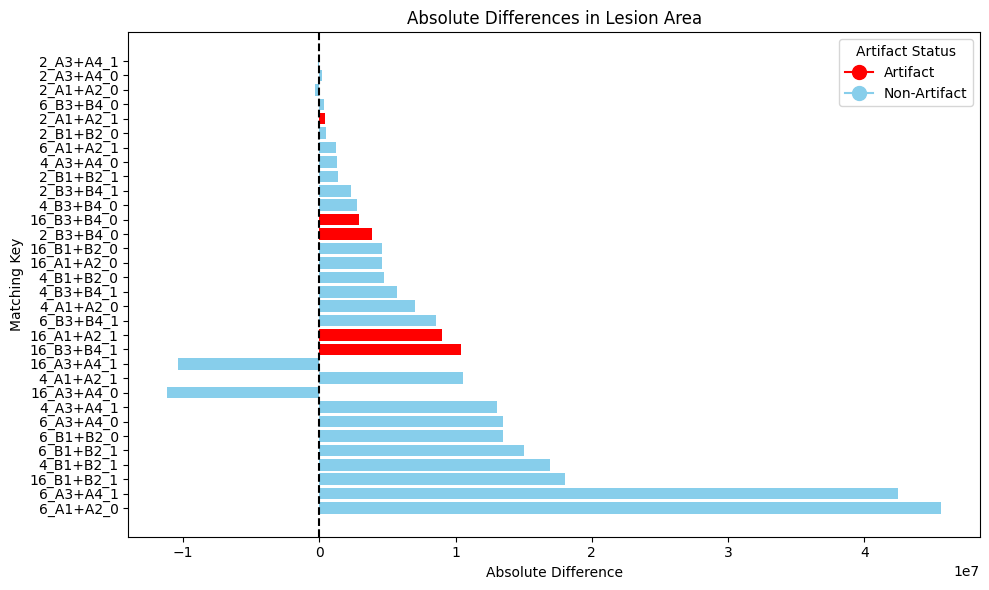

In [52]:
import matplotlib.pyplot as plt

# List of artifact-affected keys
artifact_keys = [
    '2_A1+A2_1',  # Example for w2 A1+A2 Scene 1
    '2_B3+B4_0',  # Example for w2 B3+B4 Scene 0
    '16_A1+A2_1', # Example for w16 A1+A2 Scene 1
    '16_B3+B4_0', # Example for w16 B3+B4 Scene 0
    '16_B3+B4_1', # Example for w16 B3+B4 Scene 1
]

# Add a new column in the DataFrame to indicate if the matching_key is in artifact_keys
lesion_differences_df['Is Artifact'] = lesion_differences_df['matching_key'].isin(artifact_keys)

# Assign colors based on whether the row is an artifact or not
# Use 'red' for artifacts and 'skyblue' for non-artifacts
colors = ['red' if is_artifact else 'skyblue' for is_artifact in lesion_differences_df['Is Artifact']]

# Plot absolute differences
plt.figure(figsize=(10, 6))
plt.barh(
    lesion_differences_df['matching_key'],
    lesion_differences_df['Absolute Difference'],
    color=colors
)
plt.axvline(0, color='black', linestyle='--')  # Add a vertical line at 0 for reference
plt.title('Absolute Differences in Lesion Area')
plt.xlabel('Absolute Difference')
plt.ylabel('Matching Key')

# Add a custom legend for artifact status
import matplotlib.lines as mlines
artifact_legend = mlines.Line2D([], [], marker='o', color='red', label='Artifact', markersize=10)
non_artifact_legend = mlines.Line2D([], [], marker='o', color='skyblue', label='Non-Artifact', markersize=10)
plt.legend(handles=[artifact_legend, non_artifact_legend], title='Artifact Status')


plt.tight_layout()
plt.show()


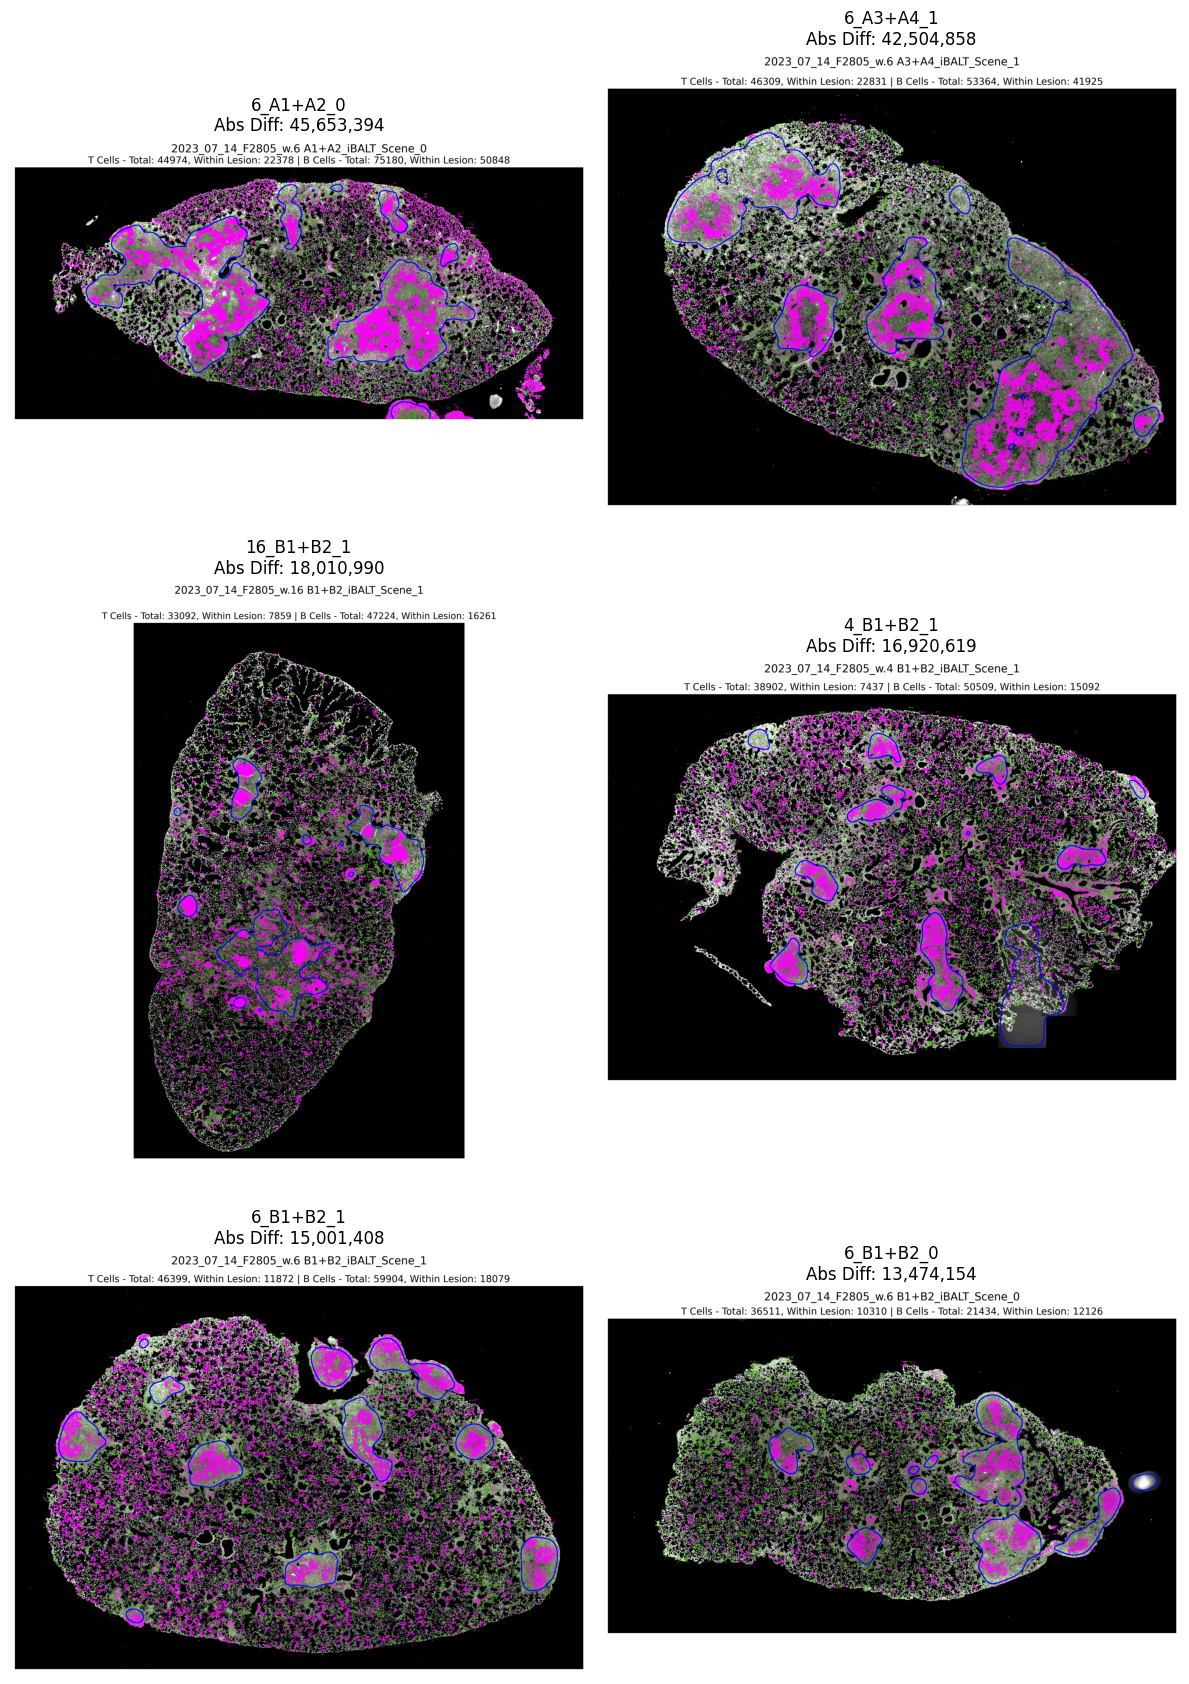

In [45]:
# Select the 6 largest positive absolute differences
top_6 = lesion_differences_df.nlargest(6, 'Absolute Difference')

import matplotlib.pyplot as plt
from PIL import Image
import os
import re

# Folder containing the images
image_folder = "processed_images"

# Initialize the plot
fig, axes = plt.subplots(3, 2, figsize=(12, 18))  # 3 rows and 2 columns
axes = axes.flatten()

# Iterate over the selected rows and plot the images
for i, (_, row) in enumerate(top_6.iterrows()):
    # Extract parts of the matching key
    week = f"w.{row['matching_key'].split('_')[0]}"
    sample_type = row['matching_key'].split('_')[1]
    scene = f"Scene_{row['matching_key'].split('_')[2]}"
    pattern = rf"{week} {re.escape(sample_type)}.*{scene}_plot\.png"
    
    # Search for a matching image file
    image_file = None
    for file in os.listdir(image_folder):
        if re.search(pattern, file):
            image_file = file
            break

    if image_file:
        # Load the image
        image_path = os.path.join(image_folder, image_file)
        img = Image.open(image_path)

        # Format the Absolute Difference with thousand separators
        abs_diff = row['Absolute Difference']
        abs_diff_formatted = f"{abs_diff:,.0f}"  # Adds a comma as a thousands separator

        # Display the image in the subplot
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"{row['matching_key']}\nAbs Diff: {abs_diff_formatted}")
    else:
        # If the image is not found, leave the subplot blank
        axes[i].axis('off')
        axes[i].set_title(f"Image not found: {row['matching_key']}")

# Adjust layout and display
plt.tight_layout()
plt.show()


# Archived

## Imputing

In [ ]:
# Identify rows with artifacts
artifact_conditions = (
    (results_df['Week'] == 2) & (results_df['Sample Type'] == 'A1+A2') & (results_df['Scene'] == 1) |
    (results_df['Week'] == 2) & (results_df['Sample Type'] == 'B3+B4') & (results_df['Scene'] == 0) |
    (results_df['Week'] == 16) & (results_df['Sample Type'] == 'A1+A2') & (results_df['Scene'] == 1) |
    (results_df['Week'] == 16) & (results_df['Sample Type'] == 'B3+B4') & (results_df['Scene'] == 0) |
    (results_df['Week'] == 16) & (results_df['Sample Type'] == 'B3+B4') & (results_df['Scene'] == 1)
)

# Group by 'Week' and calculate the median for relevant columns
grouped_medians = results_df.groupby('Week')[[
    'Tissue Area', 'Lesion Area', 'Lesion Area Ratio',
    'Total T Cells', 'T Cells in Lesion Density','T Cells in Lesion', 'T Cells in Lesion Ratio',
    'Total B Cells', 'B Cells in Lesion Density', 'B Cells in Lesion', 'B Cells in Lesion Ratio'
]].median()

# Function to impute missing or artifact rows
def impute_row(row):
    if artifact_conditions.loc[row.name]:  # Check if the row is marked as an artifact
        week_median = grouped_medians.loc[row['Week']]
        for col in week_median.index:  # Replace relevant columns with median values
            row[col] = week_median[col]
    return row

# Apply the imputation function
results_df = results_df.apply(impute_row, axis=1)

# Save the corrected DataFrame to a new CSV
results_df.to_csv('lesion_analysis_summary_corrected.csv', index=False)

# Display the corrected DataFrame
print(results_df.head())
